# セグメンテーション

In [1]:
google_colab = False

# Google Colab用事前準備

In [2]:
# install
try:
    import binarybrain as bb
except:
    if google_colab and False:
        !pip install pybind11
        %cd /content
        !nvcc -V
        !sudo rm -fr BinaryBrain
        !rm -fr BinaryBrain
        !git clone --recursive -b ver3_develop https://github.com/ryuz/BinaryBrain.git
        %cd /content/BinaryBrain/python
        !sh copy_src.sh
        !python3 setup.py build
        !python3 setup.py develop

        import binarybrain as bb

In [3]:
# mount
if google_colab:
  from google.colab import drive 
  drive.mount('/content/drive')
  %cd /content/drive/My Drive/git-work/BinaryBrain_ver3_develop/tests/python

In [4]:
device = 0

import binarybrain as bb

import importlib
importlib.reload(bb)
bb.omp_set_num_threads(4)
bb.set_device(device)
prop = bb.get_device_properties(device)
print(prop)


name                     : GeForce GTX 1660 SUPER
totalGlobalMem           : 6442450944
sharedMemPerBlock        : 49152
regsPerBlock             : 65536
warpSize                 : 32
memPitch                 : 2147483647
maxThreadsPerBlock       : 1024
maxThreadsDim[0]         : 1024
maxThreadsDim[1]         : 1024
maxThreadsDim[2]         : 64
maxGridSize[0]           : 2147483647
maxGridSize[1]           : 65535
maxGridSize[2]           : 65535
clockRate                : 1800000
totalConstMem            : 65536
major                    : 7
minor                    : 5
textureAlignment         : 512
deviceOverlap            : 1
multiProcessorCount      : 22
kernelExecTimeoutEnabled : 1
integrated               : 0
canMapHostMemory         : 1
computeMode              : 0




# メインコード

In [5]:
import binarybrain as bb
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import os
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import OrderedDict

In [6]:
epoch_size = 4
modulation_size = 3
mini_batch_size = 8

data_path = 'MnistSegDistillationTest3'
os.makedirs(data_path, exist_ok=True)
network_name = 'mnist-seg-distillation-test3'

In [7]:
def make_test_image(src_x, src_t):
    dst_x = np.ndarray((len(src_x),  1, 28, 28), dtype=np.float32)
    dst_t = np.ndarray((len(src_x), 11, 28, 28), dtype=np.float32)
    for i in range(len(src_x)):
        x_img = src_x[i].copy()
        t_img = np.zeros((11, 28*28), dtype=np.float32)
        mask0 = x_img <= 0.5
        mask1 = x_img > 0.5
        for j in range(10):
          t_img[j,mask1] = src_t[i][j]
        t_img[10,mask0] = 0.15
        dst_x[i] = x_img.reshape(1, 28, 28)
        dst_t[i] = t_img.reshape(11, 28, 28)
    return dst_x, dst_t

def make_test_data(src_x, src_t):
    x, t = make_test_image(src_x, src_t)

    dst_x = np.ndarray((len(src_x) // 4,  1*56*56), dtype=np.float32)
    dst_t = np.ndarray((len(src_x) // 4, 11*56*56), dtype=np.float32)
    for i in range(len(x) // 4):
        x_img = np.hstack((np.dstack((x[i*4+0], x[i*4+1])), np.dstack((x[i*4+2], x[i*4+3]))))
        t_img = np.hstack((np.dstack((t[i*4+0], t[i*4+1])), np.dstack((t[i*4+2], t[i*4+3]))))
        dst_x[i] = x_img.reshape(-1)
        dst_t[i] = t_img.reshape(-1)
    return dst_x, dst_t

def image_transform(img):
    angle = random.uniform(-10.0, +10.0)
    scale = random.uniform(0.8, 1.1)
    trans = cv2.getRotationMatrix2D((14, 14), angle , scale)
    trans[0][2] += random.uniform(-2.0, 2.0)
    trans[1][2] += random.uniform(-2.0, 2.0)
    return cv2.warpAffine(img.reshape(28, 28), trans, (28, 28))

def make_td_image(src_x, src_t, w=28, h=28, depth=27):
    l = len(src_x)
    mx = (28 + depth + w + depth + 27) // 28
    my = (28 + depth + h + depth + 27) // 28
    dst_x = np.zeros(( 1, 28*my, 28*mx), dtype=np.float32)
    dst_t = np.zeros((11, 28*my, 28*mx), dtype=np.float32)
    for y in range(my):
        for x in range(mx):
            i = random.randrange(0, l)
            dst_x[0,y*28:y*28+28, x*28:x*28+28] = image_transform(src_x[i])
            dst_t[0:10,y*28:y*28+28, x*28:x*28+28] = np.tile(src_t[i], (28,28)).reshape(28, 28, 10).transpose(2, 0, 1)
    x_flag0 = dst_x[0] <= 0.5
    x_flag1 = dst_x[0] >  0.5
    for i in range(10):
        dst_t[i][x_flag0] = 0
    dst_t[10][x_flag0] = 0.15  # ここ重要
    
    xs = random.randrange(0, 28)
    ys = random.randrange(0, 28)
    dst_x  = dst_x[:,ys:ys+2*depth+h,xs:xs+2*depth+w]
    x_flag = x_flag1[ys:ys+2*depth+h,xs:xs+2*depth+w]
    
    dst_t  = dst_t[:,ys+depth:ys+depth+h,xs+depth:xs+depth+w]
    t_flag = x_flag1[ys+depth:ys+depth+h,xs+depth:xs+depth+w]
    
    x_mask = np.zeros(x_flag.shape, dtype=np.float32)
    x_mask[x_flag] = 1.0
    t_mask = np.zeros(t_flag.shape, dtype=np.float32)
    t_mask[t_flag] = 1.0
    return dst_x.flatten(), dst_t.flatten(), x_mask.flatten(), t_mask.flatten()

def generate_td(src_td, train_size=5000//2, test_size=1000//2, w=28, h=28, depth=27):
    dst_td = {}
    
    dst_td['x_train']      = []
    dst_td['t_train']      = []
    dst_td['x_mask_train'] = []
    dst_td['t_mask_train'] = []
    for _ in tqdm(range(train_size)):
        x, t, xm, tm = make_td_image(src_td['x_train'], src_td['t_train'], w=w, h=h, depth=depth)
        dst_td['x_train'].append(x)
        dst_td['t_train'].append(t)
        dst_td['x_mask_train'].append(xm)
        dst_td['t_mask_train'].append(tm)
    dst_td['x_train']      = np.array(dst_td['x_train'])
    dst_td['t_train']      = np.array(dst_td['t_train'])
    dst_td['x_mask_train'] = np.array(dst_td['x_mask_train'])
    dst_td['t_mask_train'] = np.array(dst_td['t_mask_train'])
    
    dst_td['x_test']      = []
    dst_td['t_test']      = []
    dst_td['x_mask_test'] = []
    dst_td['t_mask_test'] = []
    for _ in tqdm(range(test_size)):
        x, t, xm, tm = make_td_image(src_td['x_test'], src_td['t_test'], w=w, h=h, depth=depth)
        dst_td['x_test'].append(x)
        dst_td['t_test'].append(t)
        dst_td['x_mask_test'].append(xm)
        dst_td['t_mask_test'].append(tm)
    dst_td['x_test']      = np.array(dst_td['x_test'])
    dst_td['t_test']      = np.array(dst_td['t_test'])
    dst_td['x_mask_test'] = np.array(dst_td['x_mask_test'])
    dst_td['t_mask_test'] = np.array(dst_td['t_mask_test'])
    
    dst_td['x_shape'] = [depth*2+w, depth*2+h, 1]
    dst_td['t_shape'] = [w, h, 11]
    
    return dst_td

In [8]:
color_table = [
    [0xe6, 0x00, 0x12],  # 0
    [0x92, 0x07, 0x83],  # 1
    [0x1d, 0x20, 0x88],  # 2
    [0x00, 0x68, 0xb7],  # 3
    [0x00, 0xa0, 0xe9],  # 4
    [0x00, 0x9e, 0x96],  # 5
    [0x00, 0x99, 0x44],  # 6
    [0x8f, 0xc3, 0x1f],  # 7
    [0xff, 0xf1, 0x00],  # 8
    [0xf3, 0x98, 0x00],  # 9
    [0x00, 0x00, 0x00],  # BGC
]

def frame_to_image(frame):
    idx_img = np.argmax(frame, axis=0)
    rgb_img = np.ndarray((idx_img.shape[0], idx_img.shape[1], 3), dtype=np.uint8)
    for y in range(idx_img.shape[1]):
        for x in range(idx_img.shape[0]):
            rgb_img[y][x] = color_table[idx_img[y][x]]
    return rgb_img

In [9]:
def plot_image(net, td):
    x_buf = bb.FrameBuffer()
    x_buf.resize(16, td['x_shape'])
    x_buf.set_data(td['x_test'][0:16])
    y_buf = net.forward(x_buf, False)

    data = y_buf.get_data(0)
    
    plt.subplot(141)
    frame = np.array(data[0]).reshape(56, 56, -1)
    plt.imshow(frame_to_image(frame.reshape(11, 56, 56)))
    
    plt.subplot(142)
    frame = np.array(data[1]).reshape(56, 56, -1)
    plt.imshow(frame_to_image(frame.reshape(11, 56, 56)))

    plt.subplot(143)
    frame = np.array(data[2]).reshape(56, 56, -1)
    plt.imshow(frame_to_image(frame.reshape(11, 56, 56)))

    plt.subplot(144)
    frame = np.array(data[3]).reshape(56, 56, -1)
    plt.imshow(frame_to_image(frame.reshape(11, 56, 56)))

    plt.show()

In [10]:
# load MNIST data
src_td = bb.load_mnist()

In [11]:
# 設定
layer_depth = 27
t_width     = 28*2
t_height    = 28*2

In [12]:
td = generate_td(src_td, w=t_width, h=t_height, depth=layer_depth)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 538.18it/s]


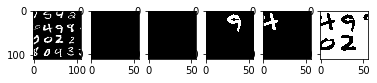

In [13]:
plt.subplot(161)
plt.imshow(td['x_train'][0].reshape(layer_depth*2+56, layer_depth*2+56), 'gray')
plt.subplot(162)
plt.imshow(td['t_train'][0].reshape(11, 56, 56)[5], 'gray')
plt.subplot(163)
plt.imshow(td['t_train'][0].reshape(11, 56, 56)[3], 'gray')
plt.subplot(164)
plt.imshow(td['t_train'][0].reshape(11, 56, 56)[9], 'gray')
plt.subplot(165)
plt.imshow(td['t_train'][0].reshape(11, 56, 56)[4], 'gray')
plt.subplot(166)
plt.imshow(td['t_train'][0].reshape(11, 56, 56)[10], 'gray')

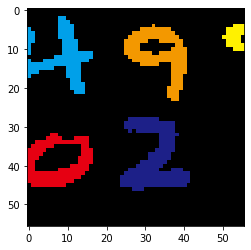

In [14]:
plt.imshow(frame_to_image(td['t_train'][0].reshape(11, 56, 56)))

# ネットワーク構築

## 蒸留用クラス

In [15]:
def lut_sort(lut, order):
    group_size  = order.shape[0]
    output_size = lut.get_output_node_size()
    input_size  = lut.get_input_node_size()
    input_unit  = input_size // group_size
    output_unit = output_size // group_size
    for g in range(group_size):
        for o in range(output_unit):
            node = g * output_unit + o
            for i in range(lut.get_node_connection_size(node)):
                idx = o*6 + i
                if idx < order.shape[1]:
                    lut.set_node_connection_index(node, i, order[g][idx])

def lut_set_serial(lut):
    output_size = lut.get_output_node_size()
    input_size  = lut.get_input_node_size()
    for n in range(output_size):
        for i in range(lut.get_node_connection_size(n)):
            idx = (n*6+i) % input_size
            lut.set_node_connection_index(n, i, idx)
            
class DistillationLayer:
    def __init__(self, layer_name):
        self.layer_name = layer_name
        
    def get_model(self):
        return self.model
    
    def switch_model(name):
        return False

    def setup_distillation(self):
        return False
    
    def save(self, path):
        pass
    
    def load(self, path):
        pass

    def save_model(self, model, name, path):
        os.makedirs(os.path.join(data_path, path, self.layer_name), exist_ok=True)
        filename = os.path.join(data_path, path, self.layer_name, '%s.json' % name)
#       print('[save] %s' % filename)
        model.save_json(filename)

    def load_model(self, model, name, path):
        filename = os.path.join(data_path, path, self.layer_name, '%s.json' % name)
        if not os.path.exists(filename):
#           print('[load error] %s' % filename)            
            return False
#       print('[load] %s' % filename)
        model.load_json(filename)
        return True
    
    
class CommonLayer(DistillationLayer):
    def __init__(self, layer_name, model, storable=False, store_name='model'):
        super(CommonLayer, self).__init__(layer_name)      
        self.model      = model
        self.storable   = storable
        self.store_name = store_name
        
    def save(self, path):
        if self.storable:
            self.save_model(self.model, path)
    
    def load(self, path):
        if self.storable:
            return self.load_model(self.model, path)
        return True

    
class ConvLayer(DistillationLayer):
    def __init__(self, layer_name, ch_size, w=3, h=3, lut_size=2, batch_norm=True, padding='valid'):
        super(ConvLayer, self).__init__(layer_name)
        
        self.distillation_flag = False
        
        # reference model
        self.affine     = bb.DenseAffine.create([ch_size])
        if batch_norm:
            self.batch_norm = bb.BatchNormalization.create()
        else:
            self.batch_norm = None
        self.activation = bb.BinarizeBit.create()
        self.ref_subnet =  bb.Sequential.create()
        self.ref_subnet.add(self.affine)
        if batch_norm:
            self.ref_subnet.add(self.batch_norm)
        self.ref_subnet.add(self.activation)
        self.ref_model = bb.LoweringConvolutionBit.create(self.ref_subnet, w, h, 1, 1, padding=padding)
        
        # target 
        self.lut_list = []
        for i in range(lut_size):
            lut = bb.SparseLut6Bit.create([ch_size*(6**i)], batch_norm=batch_norm, connection='serial')
            self.lut_list.append(lut)
        
        self.target_subnet =  bb.Sequential.create()
        for lut in (reversed(self.lut_list)):
            self.target_subnet.add(lut)
        self.target_model = bb.LoweringConvolutionBit.create(self.target_subnet, w, h, 1, 1, padding=padding)
        
        self.model = self.ref_model
    
    def switch_model(name):
        if name == 'target':
            self.model = self.target_model
            return True
        elif name == 'reference':
            self.model = self.ref_model
            return True
        return False
    
    def setup_distillation(self):
        tensorW = self.affine.W()
        W = np.array(tensorW.get_data()).reshape(tensorW.get_shape()[::-1])
        order = np.argsort(-np.abs(W), axis=1)
        
        self.target_model.set_input_shape(self.ref_model.get_input_shape())
        
        for i, lut in enumerate(self.lut_list):
            if i < len(self.lut_list) - 1:
                lut_set_serial(lut)
            else:
                lut_sort(lut, order)
        
        self.model = self.target_model
        self.distillation_flag = True
        return True
        
    def save(self, path):
        self.save_model(self.affine,     'affine',     path)
        if self.batch_norm is not None:
            self.save_model(self.batch_norm, 'batch_norm', path)
        if self.distillation_flag:
            for i, lut in enumerate(self.lut_list):
                self.save_model(lut, 'sparse_lut_%d' % i, path)
    
    def load(self, path):
        loaded = True
        loaded = self.load_model(self.affine,     'affine',     path) and loaded
        if self.batch_norm is not None:
            loaded = self.load_model(self.batch_norm, 'batch_norm', path) and loaded
        if not loaded:
            return False
        self.model = self.ref_model
        
        if self.distillation_flag:
            self.target_model.set_input_shape(self.ref_model.get_input_shape())
            
            loaded = True
            for i, lut in enumerate(self.lut_list):
                loaded = self.load_model(lut, 'sparse_lut_%d' % i, path) and loaded
            if not loaded:
                return False
            
            self.model = self.target_model
        
        return loaded

class PointwiseConvLayer(ConvLayer):
    def __init__(self, layer_name, ch_size, lut_size=2, batch_norm=True, padding='valid'):
        super(PointwiseConvLayer, self).__init__(layer_name, ch_size, w=1, h=1, lut_size=lut_size, batch_norm=batch_norm, padding=padding)

class DepthwiseConvLayer(DistillationLayer):
    def __init__(self, layer_name, out_shape, w=3, h=3, lut_size=2, batch_norm=True, connection='random', padding='valid'):
        super(DepthwiseConvLayer, self).__init__(layer_name)
        self.lut_depthwise = bb.SparseLut6Bit.create(out_shape, batch_norm=batch_norm, connection='depthwise')
        self.subnet =  bb.Sequential.create()
        self.subnet.add(self.lut_depthwise)
        self.model = bb.LoweringConvolutionBit.create(self.subnet, w, h, 1, 1, padding=padding)
    
    def save(self, path):
        self.save_model(self.lut_depthwise, 'sparse_lut', path)
        
    def load(self, path):
        return self.load_model(self.lut_depthwise, 'sparse_lut', path)

In [16]:
def build_network(layer_list):
    net = bb.Sequential.create()
    for layer in layer_list:
        net.add(layer.get_model())
    return net

def save_layers(layer_list, path):
    for layer in layer_list:
        layer.save(path)

def load_layers(layer_list, path):
    loaded = True
    for layer in layer_list:
        loaded = layer.load(path) and loaded
    return loaded

In [17]:
print(td['t_shape'])

[56, 56, 11]


In [18]:
# build network
layer_rel2bin = bb.RealToBinaryBit.create(modulation_size, framewise=True)
layer_bin2rel = bb.BinaryToRealBit.create(modulation_size)

idx = 0

layer_list = []
layer_list.append(CommonLayer('rel2bin', layer_rel2bin))

layer_list.append(DepthwiseConvLayer('depthwise_cnv%d' % idx, [32, 1, 1], 3, 3))  # 26x26
layer_list.append(PointwiseConvLayer('pointwise_cnv%d' % idx, 32, lut_size=2))
idx += 1

for i in range(25):
    layer_list.append(DepthwiseConvLayer('depthwise_cnv%d' % idx, [8, 1, 32], 3, 3)) # 24x24
    layer_list.append(PointwiseConvLayer('pointwise_cnv%d' % idx, 32, lut_size=2))
    idx += 1
   
layer_list.append(DepthwiseConvLayer('depthwise_cnv%d' % idx, [8, 1, 32], 3, 3))# 1x1
layer_list.append(PointwiseConvLayer('pointwise_cnv%d' % idx, 64, lut_size=2))
idx += 1

layer_list.append(PointwiseConvLayer('pointwise_cnv%d' % idx, 36, lut_size=2))
idx += 1

layer_list.append(PointwiseConvLayer('pointwise_cnv%d' % idx, 11, lut_size=2, batch_norm=False))
idx += 1

layer_list.append(CommonLayer('bin2rel', layer_bin2rel))

net = build_network(layer_list)
net.set_input_shape(td['x_shape'])

[56, 56, 11]

In [19]:
# 初回から全部LUTにしてしまう場合
if False:
    for layer in layer_list:
        layer.switch_model('target')
    net = build_network(layer_list)
    net.set_input_shape(td['x_shape'])

In [20]:
print(net.get_info())

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output

In [21]:
net.send_command('binary true')
        
loss    = bb.LossSoftmaxCrossEntropy.create()
metrics = bb.MetricsCategoricalAccuracy.create()

loaded = load_layers(layer_list, 'base')
print(loaded)

True


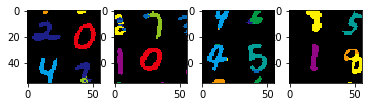

In [22]:
plot_image(net, td)

In [23]:
if not loaded:
#if True:
    optimizer = bb.OptimizerAdam.create()
    optimizer.set_variables(net.get_parameters(), net.get_gradients())
    runner = bb.Runner(net, network_name, loss, metrics, optimizer)
    for epoch in range(64):
        td = generate_td(src_td, w=t_width, h=t_height, depth=layer_depth)
        runner.fitting(td, epoch_size=1, mini_batch_size=mini_batch_size, file_write=True, file_read=False)
        plot_image(net, td)
        save_layers(layer_list, 'base')
        save_layers(layer_list, 'base_%d' % epoch)

In [24]:
save_layers(layer_list, 'base')

In [25]:
for i, layer in enumerate(layer_list):
    print(i, layer.layer_name)

0 rel2bin
1 depthwise_cnv0
2 pointwise_cnv0
3 depthwise_cnv1
4 pointwise_cnv1
5 depthwise_cnv2
6 pointwise_cnv2
7 depthwise_cnv3
8 pointwise_cnv3
9 depthwise_cnv4
10 pointwise_cnv4
11 depthwise_cnv5
12 pointwise_cnv5
13 depthwise_cnv6
14 pointwise_cnv6
15 depthwise_cnv7
16 pointwise_cnv7
17 depthwise_cnv8
18 pointwise_cnv8
19 depthwise_cnv9
20 pointwise_cnv9
21 depthwise_cnv10
22 pointwise_cnv10
23 depthwise_cnv11
24 pointwise_cnv11
25 depthwise_cnv12
26 pointwise_cnv12
27 depthwise_cnv13
28 pointwise_cnv13
29 depthwise_cnv14
30 pointwise_cnv14
31 depthwise_cnv15
32 pointwise_cnv15
33 depthwise_cnv16
34 pointwise_cnv16
35 depthwise_cnv17
36 pointwise_cnv17
37 depthwise_cnv18
38 pointwise_cnv18
39 depthwise_cnv19
40 pointwise_cnv19
41 depthwise_cnv20
42 pointwise_cnv20
43 depthwise_cnv21
44 pointwise_cnv21
45 depthwise_cnv22
46 pointwise_cnv22
47 depthwise_cnv23
48 pointwise_cnv23
49 depthwise_cnv24
50 pointwise_cnv24
51 depthwise_cnv25
52 pointwise_cnv25
53 depthwise_cnv26
54 pointwise

# 上層だけ実験

In [26]:
if False:
    i = 56
    layer_list[i].setup_distillation()
    net = build_network(layer_list)
    net.set_input_shape(td['x_shape'])
    net.send_command('binary true')
    print(net.get_info())

    net.send_command('parameter_lock true')
    layer_list[i].get_model().send_command('parameter_lock false')
    optimizer = bb.OptimizerAdam.create()
    optimizer.set_variables(net.get_parameters(), net.get_gradients())        
    runner = bb.Runner(net, network_name, loss, metrics, optimizer)
    runner.fitting(td, epoch_size=2, mini_batch_size=mini_batch_size, file_write=False, file_read=False)
    save_layers(layer_list, 'test_last')
    plot_image(net, td)

# 下層から順に蒸留

0


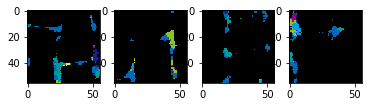

1


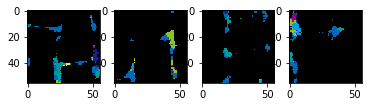

2


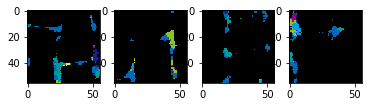

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output

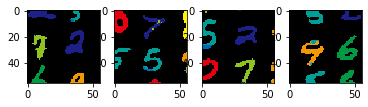

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 518.30it/s]


epoch=1 test_accuracy=0.441035 test_loss=4936.201609 train_accuracy=0.437254 train_loss=4939.016124


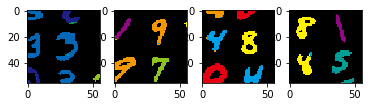

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 567.32it/s]


epoch=1 test_accuracy=0.450703 test_loss=4925.493616 train_accuracy=0.445942 train_loss=4927.733630


epoch=2 test_accuracy=0.441070 test_loss=4949.231073 train_accuracy=0.436358 train_loss=4952.000898


epoch=3 test_accuracy=0.450685 test_loss=4918.196119 train_accuracy=0.447146 train_loss=4919.283229


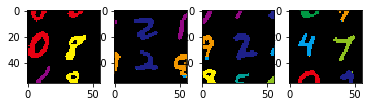

3


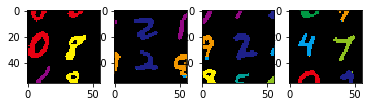

4


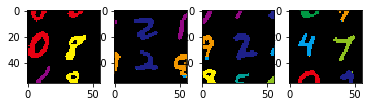

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output

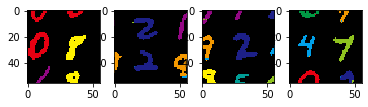

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 558.17it/s]


epoch=1 test_accuracy=0.452098 test_loss=4973.006816 train_accuracy=0.443924 train_loss=4975.440963


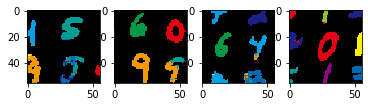

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 549.71it/s]


epoch=1 test_accuracy=0.460970 test_loss=4929.417729 train_accuracy=0.452552 train_loss=4931.794903


epoch=2 test_accuracy=0.450249 test_loss=4930.577813 train_accuracy=0.443246 train_loss=4931.527069


epoch=3 test_accuracy=0.450711 test_loss=4941.626561 train_accuracy=0.444088 train_loss=4942.754929


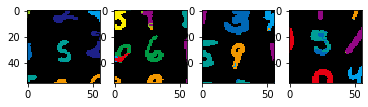

5


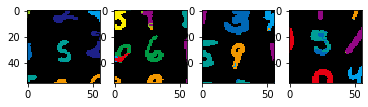

6


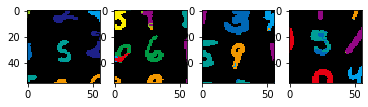

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output

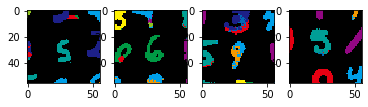

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 588.53it/s]


epoch=1 test_accuracy=0.450549 test_loss=4958.590978 train_accuracy=0.446650 train_loss=4961.230207


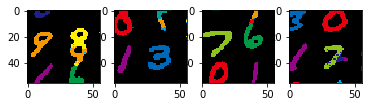

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 563.56it/s]


epoch=1 test_accuracy=0.456974 test_loss=4916.948367 train_accuracy=0.452178 train_loss=4918.256571


epoch=2 test_accuracy=0.455017 test_loss=4976.426983 train_accuracy=0.451045 train_loss=4979.040080


epoch=3 test_accuracy=0.414600 test_loss=4955.465934 train_accuracy=0.409961 train_loss=4958.196011


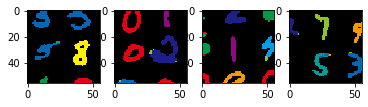

7


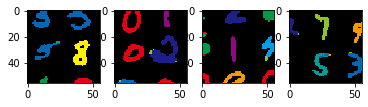

8


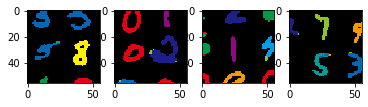

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output

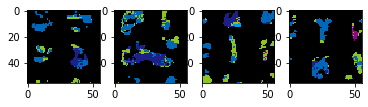

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 528.57it/s]


epoch=1 test_accuracy=0.458152 test_loss=4935.721682 train_accuracy=0.451973 train_loss=4939.372190


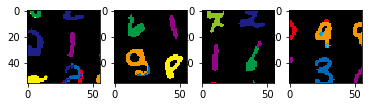

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 526.76it/s]


epoch=1 test_accuracy=0.446757 test_loss=4949.259181 train_accuracy=0.446089 train_loss=4951.916455


epoch=2 test_accuracy=0.449379 test_loss=4923.701270 train_accuracy=0.449571 train_loss=4925.209900


epoch=3 test_accuracy=0.453007 test_loss=4946.380377 train_accuracy=0.453911 train_loss=4947.755191


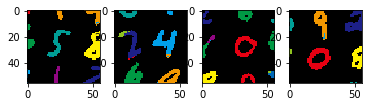

9


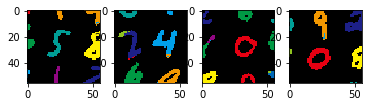

10


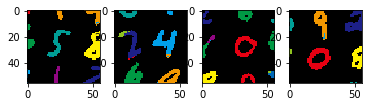

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output

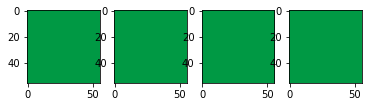

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 544.46it/s]


epoch=1 test_accuracy=0.448357 test_loss=4929.661664 train_accuracy=0.442750 train_loss=4931.912328


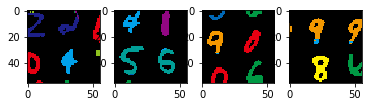

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 546.97it/s]


epoch=1 test_accuracy=0.450934 test_loss=4975.791312 train_accuracy=0.450833 train_loss=4978.100963


epoch=2 test_accuracy=0.452082 test_loss=4950.244147 train_accuracy=0.451601 train_loss=4952.373543


epoch=3 test_accuracy=0.424035 test_loss=4959.691176 train_accuracy=0.421520 train_loss=4962.981099


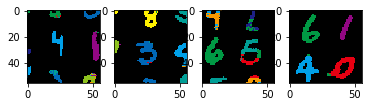

11


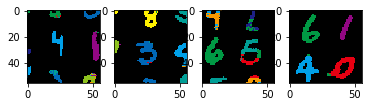

12


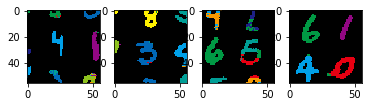

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output

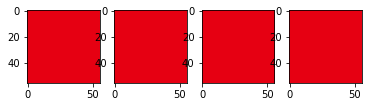

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 537.27it/s]


epoch=1 test_accuracy=0.451367 test_loss=4915.433319 train_accuracy=0.441093 train_loss=4917.715701


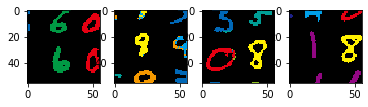

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 522.98it/s]


epoch=1 test_accuracy=0.447955 test_loss=4959.037985 train_accuracy=0.445803 train_loss=4960.989331


epoch=2 test_accuracy=0.271065 test_loss=5472.545921 train_accuracy=0.264007 train_loss=5481.698006


epoch=3 test_accuracy=0.445401 test_loss=4923.464587 train_accuracy=0.441980 train_loss=4925.734264


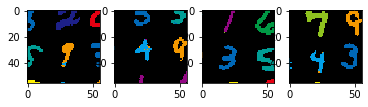

13


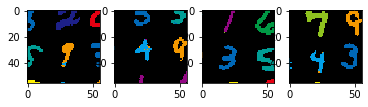

14


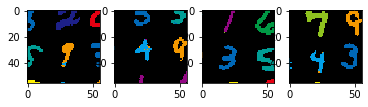

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output

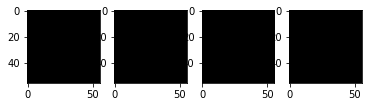

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 507.46it/s]


epoch=1 test_accuracy=0.421755 test_loss=4945.984280 train_accuracy=0.420423 train_loss=4946.132620


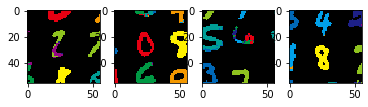

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 548.64it/s]


epoch=1 test_accuracy=0.450701 test_loss=4924.619238 train_accuracy=0.450998 train_loss=4926.054515


epoch=2 test_accuracy=0.444612 test_loss=4927.561359 train_accuracy=0.443648 train_loss=4929.224870


epoch=3 test_accuracy=0.435756 test_loss=4945.578368 train_accuracy=0.437710 train_loss=4945.729878


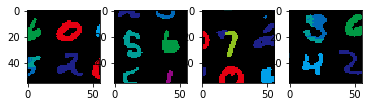

15


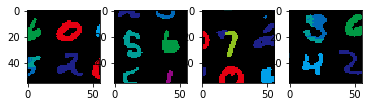

16


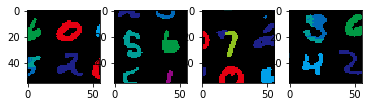

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output

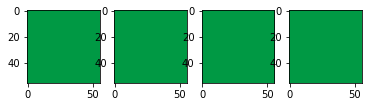

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 387.70it/s]


epoch=1 test_accuracy=0.450776 test_loss=4939.040274 train_accuracy=0.445577 train_loss=4943.026390


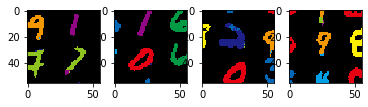

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 489.27it/s]


epoch=1 test_accuracy=0.451671 test_loss=4932.459062 train_accuracy=0.446875 train_loss=4934.212916


epoch=2 test_accuracy=0.453774 test_loss=4948.915102 train_accuracy=0.450132 train_loss=4950.852855


epoch=3 test_accuracy=0.454935 test_loss=4939.953358 train_accuracy=0.448947 train_loss=4943.177016


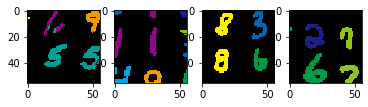

17


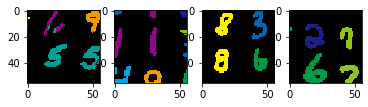

18


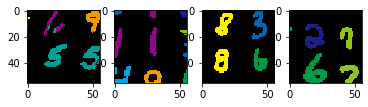

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output

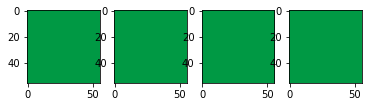

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 574.91it/s]


epoch=1 test_accuracy=0.432691 test_loss=4928.530247 train_accuracy=0.426803 train_loss=4931.461267


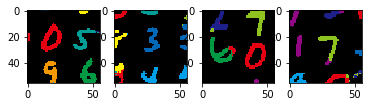

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 571.64it/s]


epoch=1 test_accuracy=0.442260 test_loss=4918.338358 train_accuracy=0.443427 train_loss=4920.249912


epoch=2 test_accuracy=0.410316 test_loss=4952.320596 train_accuracy=0.404896 train_loss=4959.325986


epoch=3 test_accuracy=0.450765 test_loss=4946.557066 train_accuracy=0.450501 train_loss=4951.002549


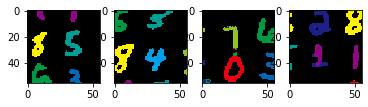

19


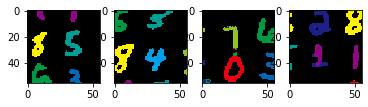

20


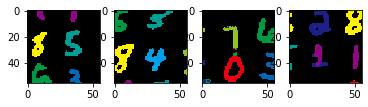

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output

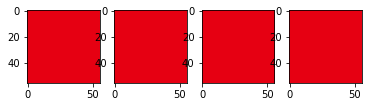

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 578.07it/s]


epoch=1 test_accuracy=0.436460 test_loss=4944.686490 train_accuracy=0.426692 train_loss=4948.958405


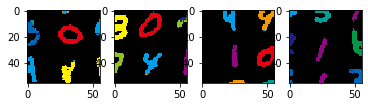

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 555.37it/s]


epoch=1 test_accuracy=0.447715 test_loss=4935.864810 train_accuracy=0.442477 train_loss=4938.221220


epoch=2 test_accuracy=0.425785 test_loss=4925.594992 train_accuracy=0.419291 train_loss=4927.476050


epoch=3 test_accuracy=0.452208 test_loss=4953.038989 train_accuracy=0.448118 train_loss=4955.624743


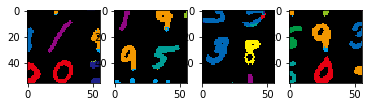

21


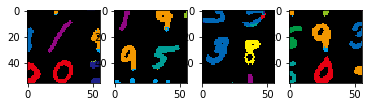

22


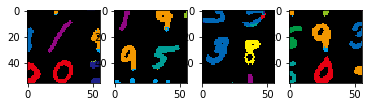

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output

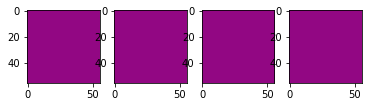

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 503.90it/s]


epoch=1 test_accuracy=0.451567 test_loss=4953.330094 train_accuracy=0.443733 train_loss=4958.188533


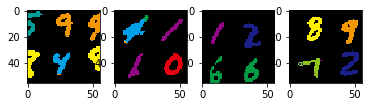

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 522.64it/s]


epoch=1 test_accuracy=0.451546 test_loss=4920.862376 train_accuracy=0.444783 train_loss=4923.311001


epoch=2 test_accuracy=0.451662 test_loss=4928.719562 train_accuracy=0.444440 train_loss=4931.325988


epoch=3 test_accuracy=0.443177 test_loss=4923.343073 train_accuracy=0.438127 train_loss=4924.330280


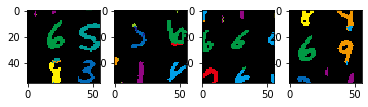

23


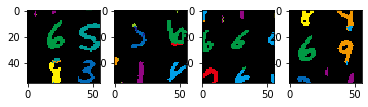

24


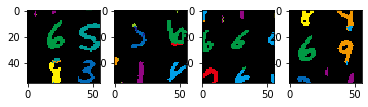

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output

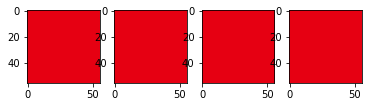

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 225.73it/s]


epoch=1 test_accuracy=0.448627 test_loss=4955.700850 train_accuracy=0.444037 train_loss=4959.163251


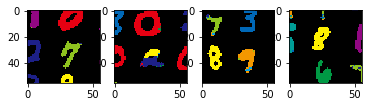

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 544.84it/s]


epoch=1 test_accuracy=0.422132 test_loss=4970.707686 train_accuracy=0.418996 train_loss=4975.332463


epoch=2 test_accuracy=0.384780 test_loss=4935.748284 train_accuracy=0.378319 train_loss=4941.091288


epoch=3 test_accuracy=0.443119 test_loss=4931.282802 train_accuracy=0.439747 train_loss=4935.346979


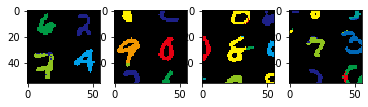

25


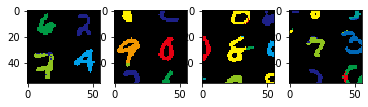

26


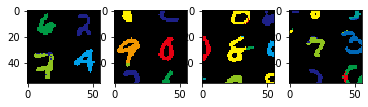

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output

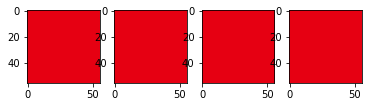

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 501.20it/s]


epoch=1 test_accuracy=0.446856 test_loss=4928.298653 train_accuracy=0.436403 train_loss=4929.721477


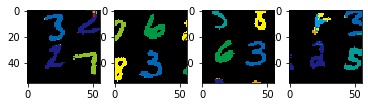

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 381.45it/s]


epoch=1 test_accuracy=0.434864 test_loss=4952.079966 train_accuracy=0.434557 train_loss=4953.010765


epoch=2 test_accuracy=0.435123 test_loss=4938.992729 train_accuracy=0.434253 train_loss=4939.746728


epoch=3 test_accuracy=0.399261 test_loss=5023.301511 train_accuracy=0.402477 train_loss=5021.235511


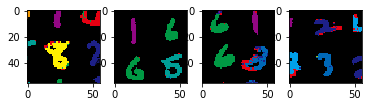

27


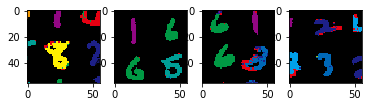

28


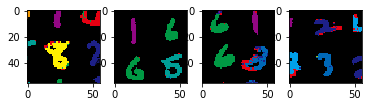

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output

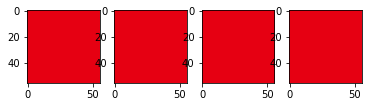

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 500.34it/s]


epoch=1 test_accuracy=0.420972 test_loss=4977.389249 train_accuracy=0.418446 train_loss=4979.205129


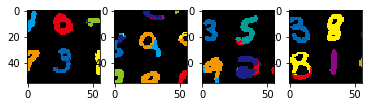

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 467.57it/s]


epoch=1 test_accuracy=0.442045 test_loss=4939.954862 train_accuracy=0.441280 train_loss=4943.608357


epoch=2 test_accuracy=0.431561 test_loss=4917.051942 train_accuracy=0.428573 train_loss=4919.949403


epoch=3 test_accuracy=0.446344 test_loss=4934.844270 train_accuracy=0.445258 train_loss=4937.765580


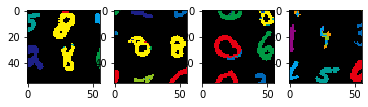

29


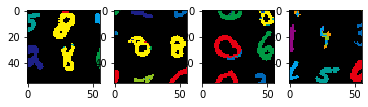

30


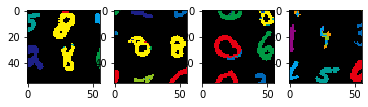

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output

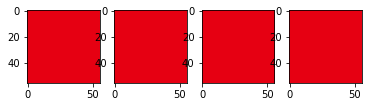

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 541.31it/s]


epoch=1 test_accuracy=0.445130 test_loss=4939.283963 train_accuracy=0.442281 train_loss=4940.831176


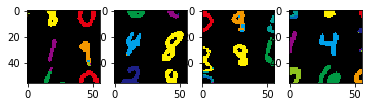

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 532.65it/s]


epoch=1 test_accuracy=0.423088 test_loss=5169.065615 train_accuracy=0.419864 train_loss=5171.583255


epoch=2 test_accuracy=0.182042 test_loss=5761.118817 train_accuracy=0.173444 train_loss=5773.313793


epoch=3 test_accuracy=0.393553 test_loss=5087.229373 train_accuracy=0.389181 train_loss=5089.372066


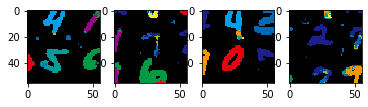

31


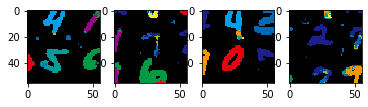

32


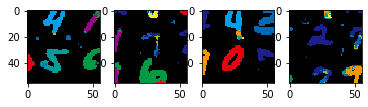

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output

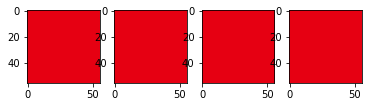

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 540.71it/s]


epoch=1 test_accuracy=0.425798 test_loss=4967.218587 train_accuracy=0.418554 train_loss=4970.265966


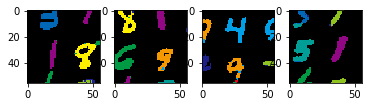

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 558.83it/s]


epoch=1 test_accuracy=0.401484 test_loss=4996.411084 train_accuracy=0.399322 train_loss=5000.779843


epoch=2 test_accuracy=0.440277 test_loss=4941.332564 train_accuracy=0.441806 train_loss=4941.905301


epoch=3 test_accuracy=0.431156 test_loss=4943.391751 train_accuracy=0.429280 train_loss=4947.019977


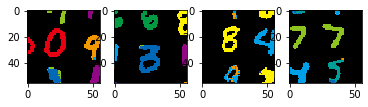

33


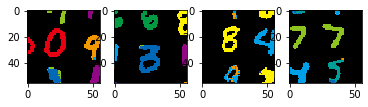

34


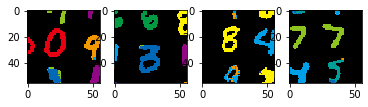

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output

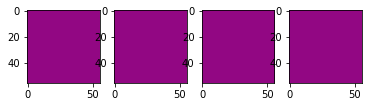

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 532.09it/s]


epoch=1 test_accuracy=0.445710 test_loss=4968.096664 train_accuracy=0.440557 train_loss=4970.805828


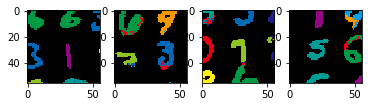

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 546.63it/s]


epoch=1 test_accuracy=0.445521 test_loss=4931.689553 train_accuracy=0.441403 train_loss=4933.735675


epoch=2 test_accuracy=0.435711 test_loss=4932.251251 train_accuracy=0.432458 train_loss=4933.527359


epoch=3 test_accuracy=0.170698 test_loss=5781.903280 train_accuracy=0.158324 train_loss=5800.139705


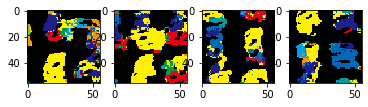

35


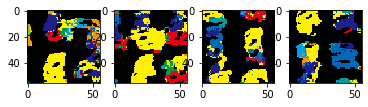

36


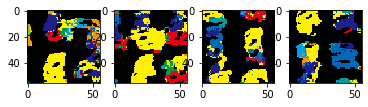

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output

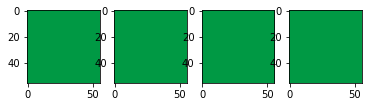

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 424.94it/s]


epoch=1 test_accuracy=0.444478 test_loss=4955.933469 train_accuracy=0.433973 train_loss=4961.280512


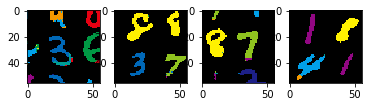

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 495.21it/s]


epoch=1 test_accuracy=0.429796 test_loss=5008.758050 train_accuracy=0.423646 train_loss=5010.587219


epoch=2 test_accuracy=0.433401 test_loss=4925.236412 train_accuracy=0.428496 train_loss=4925.622178


epoch=3 test_accuracy=0.444914 test_loss=4950.794390 train_accuracy=0.437725 train_loss=4953.461199


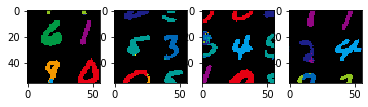

37


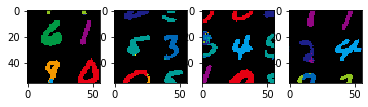

38


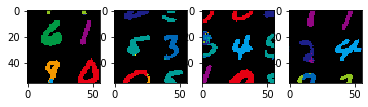

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output

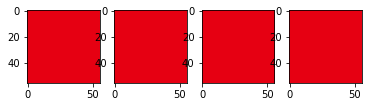

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 481.39it/s]


epoch=1 test_accuracy=0.433122 test_loss=4965.540278 train_accuracy=0.427876 train_loss=4971.993869


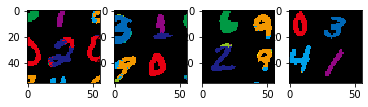

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 517.07it/s]


epoch=1 test_accuracy=0.433821 test_loss=4945.489609 train_accuracy=0.428750 train_loss=4948.815976


epoch=2 test_accuracy=0.435669 test_loss=4937.473840 train_accuracy=0.433353 train_loss=4938.838765


epoch=3 test_accuracy=0.365903 test_loss=5067.599998 train_accuracy=0.361675 train_loss=5070.827019


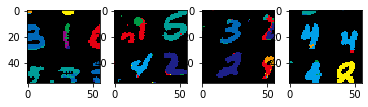

39


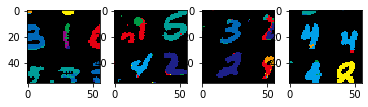

40


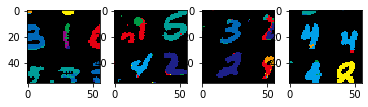

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output

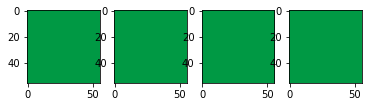

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 527.45it/s]


epoch=1 test_accuracy=0.371767 test_loss=4956.430048 train_accuracy=0.367293 train_loss=4957.288550


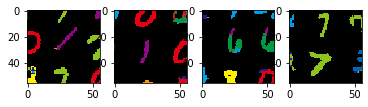

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 529.33it/s]


epoch=1 test_accuracy=0.434102 test_loss=5012.725572 train_accuracy=0.436097 train_loss=5014.804405


epoch=2 test_accuracy=0.419838 test_loss=4930.126494 train_accuracy=0.422976 train_loss=4931.321568


epoch=3 test_accuracy=0.431387 test_loss=4936.534563 train_accuracy=0.432756 train_loss=4938.825540


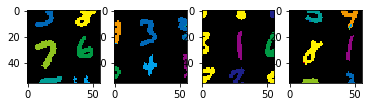

41


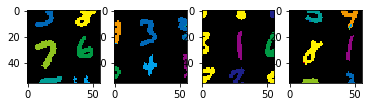

42


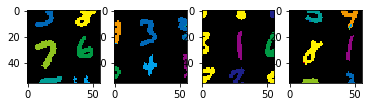

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output

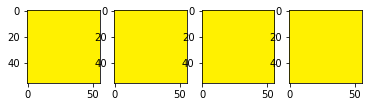

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 399.81it/s]


epoch=1 test_accuracy=0.435643 test_loss=4973.338706 train_accuracy=0.427635 train_loss=4980.200767


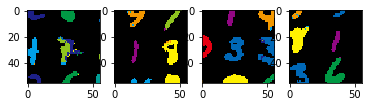

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 502.75it/s]


epoch=1 test_accuracy=0.441736 test_loss=4966.392470 train_accuracy=0.431550 train_loss=4970.711237


epoch=2 test_accuracy=0.121311 test_loss=6879.954064 train_accuracy=0.117248 train_loss=6893.903964


epoch=3 test_accuracy=0.435722 test_loss=4968.160648 train_accuracy=0.426143 train_loss=4971.201690


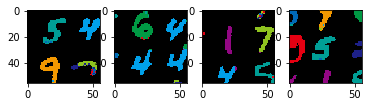

43


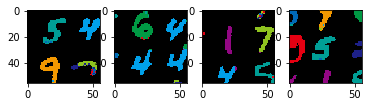

44


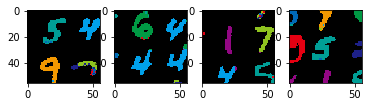

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output

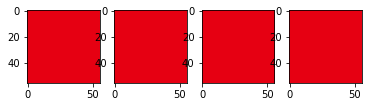

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 457.10it/s]


epoch=1 test_accuracy=0.423579 test_loss=4953.532188 train_accuracy=0.414857 train_loss=4954.802721


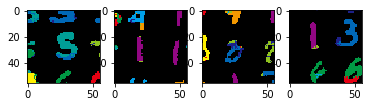

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 459.73it/s]


epoch=1 test_accuracy=0.431844 test_loss=4980.538288 train_accuracy=0.430013 train_loss=4984.222509


epoch=2 test_accuracy=0.436391 test_loss=4984.209047 train_accuracy=0.436075 train_loss=4987.846853


epoch=3 test_accuracy=0.178697 test_loss=5414.650758 train_accuracy=0.175164 train_loss=5417.565754


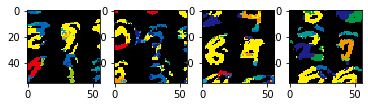

45


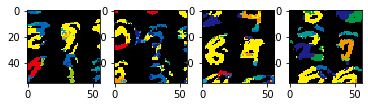

46


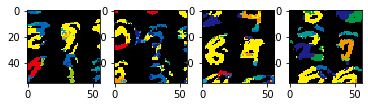

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output

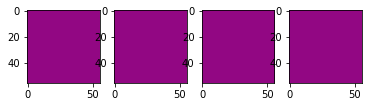

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 507.21it/s]


epoch=1 test_accuracy=0.428768 test_loss=4964.086158 train_accuracy=0.421281 train_loss=4968.668865


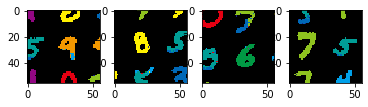

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 490.84it/s]


epoch=1 test_accuracy=0.122949 test_loss=6256.650284 train_accuracy=0.124987 train_loss=6255.608889


epoch=2 test_accuracy=0.423882 test_loss=4966.950955 train_accuracy=0.418052 train_loss=4969.025967


epoch=3 test_accuracy=0.428842 test_loss=5015.167260 train_accuracy=0.422531 train_loss=5019.712285


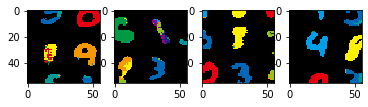

47


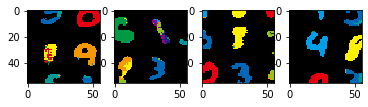

48


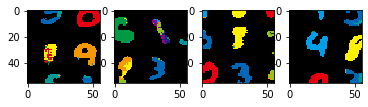

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output

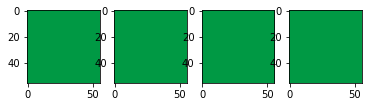

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 476.03it/s]


epoch=1 test_accuracy=0.428195 test_loss=4976.942444 train_accuracy=0.424337 train_loss=4981.913841


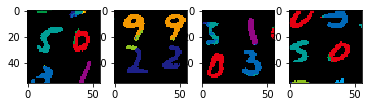

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 510.30it/s]


epoch=1 test_accuracy=0.433928 test_loss=4958.687589 train_accuracy=0.426460 train_loss=4960.910223


epoch=2 test_accuracy=0.430602 test_loss=4968.980986 train_accuracy=0.423698 train_loss=4971.010052


epoch=3 test_accuracy=0.417481 test_loss=4965.885953 train_accuracy=0.408928 train_loss=4968.486688


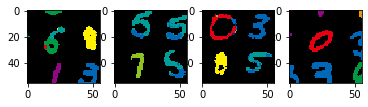

49


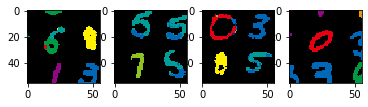

50


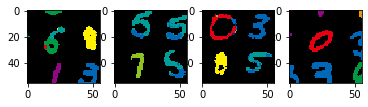

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output

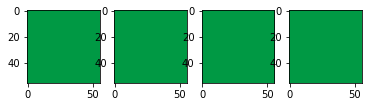

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 520.45it/s]


epoch=1 test_accuracy=0.437013 test_loss=5006.307322 train_accuracy=0.428616 train_loss=5008.570482


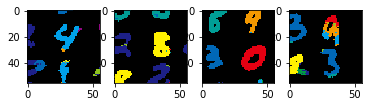

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 522.10it/s]


epoch=1 test_accuracy=0.434153 test_loss=4971.108656 train_accuracy=0.425235 train_loss=4975.772757


epoch=2 test_accuracy=0.426495 test_loss=4987.554038 train_accuracy=0.417888 train_loss=4993.216388


epoch=3 test_accuracy=0.318898 test_loss=5187.788353 train_accuracy=0.315256 train_loss=5191.640061


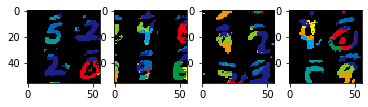

51


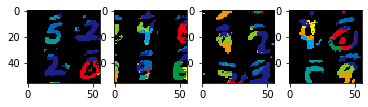

52


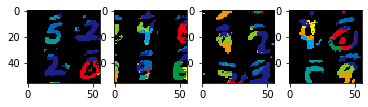

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output

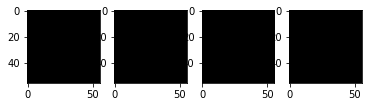

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 537.81it/s]


epoch=1 test_accuracy=0.421805 test_loss=4995.473441 train_accuracy=0.417694 train_loss=5000.487792


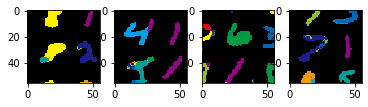

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 549.64it/s]


epoch=1 test_accuracy=0.436428 test_loss=4970.735843 train_accuracy=0.431498 train_loss=4974.562110


epoch=2 test_accuracy=0.436248 test_loss=5011.221986 train_accuracy=0.430969 train_loss=5016.124571


epoch=3 test_accuracy=0.436618 test_loss=5032.584087 train_accuracy=0.431944 train_loss=5036.201563


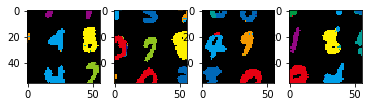

53


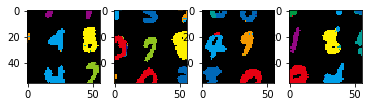

54


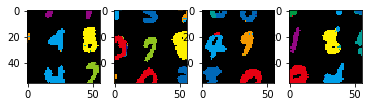

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output

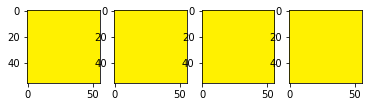

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 527.04it/s]


epoch=1 test_accuracy=0.435589 test_loss=4996.637656 train_accuracy=0.431939 train_loss=5001.756152


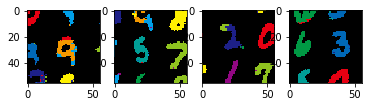

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 538.39it/s]


epoch=1 test_accuracy=0.443849 test_loss=5008.457281 train_accuracy=0.437347 train_loss=5015.505256


epoch=2 test_accuracy=0.431062 test_loss=5006.431655 train_accuracy=0.424193 train_loss=5015.414850


epoch=3 test_accuracy=0.436105 test_loss=5086.015734 train_accuracy=0.429166 train_loss=5094.728851


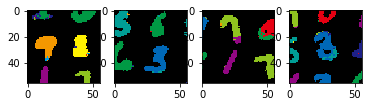

55


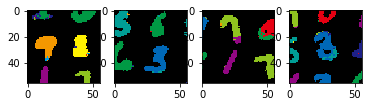

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output

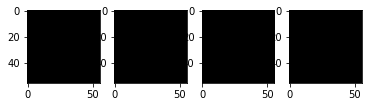

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 563.23it/s]


epoch=1 test_accuracy=0.426933 test_loss=4992.226003 train_accuracy=0.420290 train_loss=4998.965749


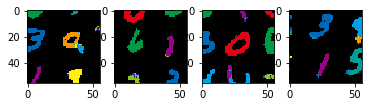

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 562.62it/s]


epoch=1 test_accuracy=0.106914 test_loss=6663.789864 train_accuracy=0.106346 train_loss=6662.310824


epoch=2 test_accuracy=0.441463 test_loss=5088.956191 train_accuracy=0.437620 train_loss=5095.684039


epoch=3 test_accuracy=0.432754 test_loss=5041.626689 train_accuracy=0.430207 train_loss=5046.373933


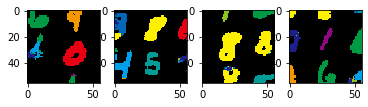

56


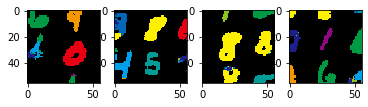

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output

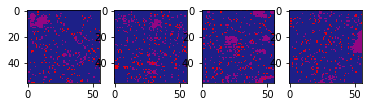

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 550.23it/s]


epoch=1 test_accuracy=0.275771 test_loss=5011.020457 train_accuracy=0.272232 train_loss=5012.211370


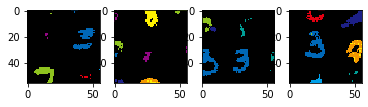

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 561.98it/s]


epoch=1 test_accuracy=0.000013 test_loss=5293.760491 train_accuracy=0.000016 train_loss=5290.593989


epoch=2 test_accuracy=0.374145 test_loss=4975.524211 train_accuracy=0.369122 train_loss=4977.872065


epoch=3 test_accuracy=0.396645 test_loss=4977.374913 train_accuracy=0.388877 train_loss=4979.922664


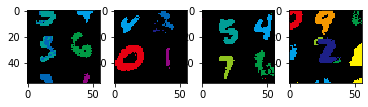

57


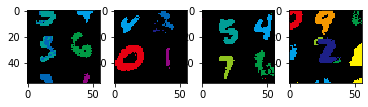

In [28]:
loss    = bb.LossSoftmaxCrossEntropy.create()
metrics = bb.MetricsCategoricalAccuracy.create()

for i, layer in enumerate(layer_list):
    print(i)
    plot_image(net, td)
    if layer_list[i].setup_distillation():
        if not load_layers(layer_list, '%03d' % i):
            net = build_network(layer_list)
            net.set_input_shape(td['x_shape'])
            net.send_command('binary true')
            print(net.get_info())
            plot_image(net, td)
            
            net.send_command('parameter_lock true')
            layer_list[i].get_model().send_command('parameter_lock false')
            optimizer = bb.OptimizerAdam.create()
            optimizer.set_variables(net.get_parameters(), net.get_gradients())        
            runner = bb.Runner(net, network_name, loss, metrics, optimizer)
            for epoch in range(1):
                td = generate_td(src_td, w=t_width, h=t_height, depth=layer_depth)
                runner.fitting(td, epoch_size=1, mini_batch_size=mini_batch_size, file_write=False, file_read=False)
                save_layers(layer_list, '%03d' % i)
                plot_image(net, td)
        
        if not load_layers(layer_list, '%03df' % i):
            net.send_command('parameter_lock false')
            optimizer = bb.OptimizerAdam.create()
            optimizer.set_variables(net.get_parameters(), net.get_gradients())
            runner = bb.Runner(net, network_name, loss, metrics, optimizer)
            for epoch in range(1):
                td = generate_td(src_td, w=t_width, h=t_height, depth=layer_depth)
                runner.fitting(td, epoch_size=3, mini_batch_size=mini_batch_size, file_write=False, file_read=False)
                save_layers(layer_list, '%03df' % i)
                plot_image(net, td)


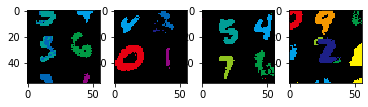

In [29]:
plot_image(net, td)

# ラスト

In [ ]:
for layer in layer_list:
    layer.setup_distillation()

net = build_network(layer_list)
net.set_input_shape(td['x_shape'])
net.send_command('binary true')
print(net.get_info())

In [ ]:
load_layers(layer_list, 'last')

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 512.42it/s]


epoch=1 test_accuracy=0.410916 test_loss=4965.193098 train_accuracy=0.401419 train_loss=4967.442085


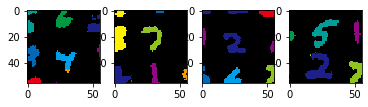

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 475.63it/s]


epoch=1 test_accuracy=0.290421 test_loss=5049.614913 train_accuracy=0.282647 train_loss=5049.176545


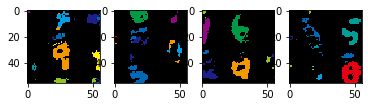

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 500.47it/s]


epoch=1 test_accuracy=0.379991 test_loss=4961.306014 train_accuracy=0.383431 train_loss=4963.172006


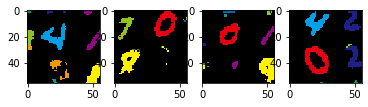

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 265.09it/s]


epoch=1 test_accuracy=0.409137 test_loss=4974.009932 train_accuracy=0.399923 train_loss=4976.496320


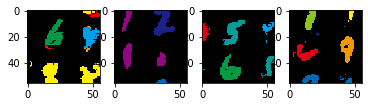

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 333.88it/s]


epoch=1 test_accuracy=0.312411 test_loss=5007.390005 train_accuracy=0.311618 train_loss=5009.155701


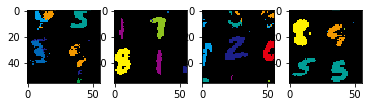

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 334.86it/s]


KeyboardInterrupt: 

In [31]:
net.send_command('parameter_lock false')
optimizer = bb.OptimizerAdam.create()
optimizer.set_variables(net.get_parameters(), net.get_gradients())
runner = bb.Runner(net, network_name, loss, metrics, optimizer)
for i in range(8):
    td = generate_td(src_td, w=t_width, h=t_height, depth=layer_depth)
    runner.fitting(td, epoch_size=1, mini_batch_size=mini_batch_size, file_write=False, file_read=False)
    plot_image(net, td)
    save_layers(layer_list, 'last2')
    save_layers(layer_list, 'last2_%d' % i)

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def print_layer_graph(lut):
    output_size = lut.get_output_node_size()
    input_size  = lut.get_input_node_size()

    G = nx.Graph()
    for i in range(input_size):
        G.add_node('in%d' % i)
    for o in range(output_size):
        G.add_node('out%d' % o)

    for o in range(output_size):
        for l in range(6):
            i = lut.get_node_connection_index(o, l)
            G.add_edge('in%d' % i, 'out%d' % o)

    pos = {}
    in_space  = 1 / (input_size + 1)
    for i in range(input_size):
        pos['in%d' % i] = (0, (i+1)*in_space)
    out_space = 1 / (output_size + 1)
    for o in range(output_size):
        pos['out%d' % o] = (1, (o+1)*out_space)

    nx.draw_networkx(G, pos=pos, node_color="c")
    plt.show()

In [ ]:
plt.figure(figsize=(16, 16))
print_layer_graph(layer_list[16].lut_list[1])